In [1]:
import agent_env as mrl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from importlib import reload
import numpy.random as rnd
from dataclasses import dataclass
import itertools

In [2]:
# simulation func for iterator-function
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)
    
    
# State class declaration
class State:
    pass

# process class
@dataclass
class OrnsteinOuhlenbeck:
    # implement internal class - State, storing process parameters and price
    @dataclass
    class State:
        price:   float = 1
    # process parameters :        
    kappa:   float = 1
    sigma:   float = 0.1
    theta:   float = 1
    dt:      float = 0.01
    sqrt_dt: float = 0.1

        
    def next_state(self, state: State) -> State:
        return OrnsteinOuhlenbeck.State(
            # price St+1 = St + theta * (kappa - St) * dt + sigma * dWt
            price = state.price + self.theta * (self.kappa - state.price)\
                * self.dt + self.sigma * np.random.normal(0, self.sqrt_dt)
        )
     
# trace generator function
def ou_price_traces(
        start_price: float = 1,
        kappa:       float = 1,
        sigma:       float = 0.1,
        theta:       float = 1,
        dt:          float = 0.01,
        time_steps:  int   = 100,
        num_traces:  int   = 1,
        random_state: int  = 0) -> np.ndarray:
    
    if random_state :
        np.random.seed(random_state)
        
    process = OrnsteinOuhlenbeck(
            kappa=kappa,
            sigma=sigma,
            theta=theta,
            dt=dt,
            sqrt_dt=np.sqrt(dt)
    )
    start_state = OrnsteinOuhlenbeck.State(price=start_price)
    return np.vstack([
            np.fromiter((s.price
                    for s in itertools.islice(simulation(process, start_state),
                                             time_steps)), float)
            for _ in range(num_traces)])

In [3]:
'''
    implementation for OU process (prices) environment

        action_space (available actions) as a dictionary, action_n - quantity of available actions
        state_space (possible states) as np.array of int, space_n - len(state_space)
        state, done = env.reset()
        state, reward, done, info = env.step(action)
    
    we define action_space as ['open_long', 'close_long', 'open_short', 'close_short'], action_n = 4
    state_space as stdev so it's [-4, -3, .. 0, 1, .. 4], state_n = 9
    reward as pnl by the next definition r_i = (close_i+2 - close_i) / close_i

'''
class OU_env:
    
    # by default if we don't send a process states as input we create new trace
    def __init__(self, 
                 random_state : int   = 0, 
                 states : np.ndarray  = None,
                 sma_window : int     = 50,
                 pnl_step : int       = 2,
                 risk_avertive : bool = True
                ):
        '''
            initialize environment with provided prices trace or generate a random new
            then create states sequence as a feed for RL-agent with rewards for actions input
        '''
        
        self.risk_avertive = risk_avertive  # to define state format
        self.random_state  = random_state   # to make available a repetition
        self.sma_window    = sma_window     # defines sma for algorithmic strategy
        
        # if prices trace was not provided -> generate a new one
        if states is None:
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
        else:
            self.states = pd.DataFrame(data=states, columns=['price'])
            
        # use prices to create states for the process
        self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
        self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
        self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
        self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
        
        self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).fillna(0).astype(int)
        self.states['position']  = 0
        
        self.step_number    = self.sma_window - 1   # indexer for pd.dataframe
        self.pnl_step       = pnl_step              # to calculate reward as pnl after pnl_step time steps
        
        # usable for RL parameters
        self.done           = False
        self.state          = self.states['state'][self.step_number]
        self.action_space   = {'open_long' : 0, 'close_long' : 1, 'open_short' : 2, 'close_short' : 3}
        self.action_n       = len(self.action_space) 
        self.state_space    = np.arange(-4, 5, 1)
        self.state_n        = len(self.state_space)
        
    def reset(self, new_trace=False):
        if new_trace:
            self.step_number    = self.sma_window - 1
            self.done           = False
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
            
            # use prices to create states for the process
            self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
            self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
            self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
            self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
            self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).fillna(0).astype(int)
            self.states['position']  = 0
            
        else:
            self.step_number         = self.sma_window - 1
            self.done                = False
            self.state               = self.states['state'][self.step_number].astype(int)
            self.states['position']  = 0
            
        if self.risk_avertive:
            return (self.state, self.states['position'][self.step_number]), self.done
        else:          
            return self.state, self.done
    
    def step(self, action):
        '''
            on each step increment step_number(index for df)
            according to input action calculate and return 
            state, reward, done, info (='info')
        '''
        if self.step_number >= (len(self.states) - 1 - self.pnl_step) :
            self.done = True
            self.state = 0
            reward = 0
            info   = 'info'
        
        # since we define reward (pnl) via close_i+pnl_step, subtract pnl_step from the last step
        else :
            self.step_number += 1
            info   = 'info'
            self.state = self.states['state'][self.step_number]
            
            # OK, let reward to be the next eq: r_i = sign(action) * ( close_(i+-pnl_step) - close_i ) / close_i
            
            # %2 == 0 means we open position !
            if (self.action_space.get(action) % 2) == 0:
                
                if ( self.states.loc[self.step_number - 1, 'position'] * (1 - self.action_space.get(action)) ) < 0 :
                    # change position
                    self.states.loc[self.step_number, 'position'] = 1 - self.action_space.get(action)
                else:
                    # increase position
                    self.states.loc[self.step_number, 'position'] =\
                        self.states.loc[self.step_number - 1, 'position'] + 1 - self.action_space.get(action)
                
                # additional multiplier to encourage the agent to open position when there's a large deviation
                multiplier = abs(self.states['state'][self.step_number]) + 1
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number + self.pnl_step] - self.states['price'][self.step_number])\
                            / self.states['price'][self.step_number] * self.states['position'][self.step_number] * multiplier
                
            # close position => define reward as : sign(action) * ( close_(i) - close_(i-pnl_step) ) / close_(i-pnl_step)
            else:
                
                # set new position
                self.states.loc[self.step_number, 'position'] = 0
                
                # the same logic to encourage to close position when the price is near SMA
                multiplier = 2 - abs(self.states['state'][self.step_number])
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number] - self.states['price'][self.step_number - self.pnl_step])\
                            / self.states['price'][self.step_number - self.pnl_step] * self.states['position'][self.step_number] * multiplier

        if self.risk_avertive:
            return (self.state, self.states['position'][self.step_number]), reward, self.done, info
        else:
            return self.state, reward, self.done, info
        
    # use positioned env trace to calc pnl
    def vector_backtest(self, cost_bps=0, render=True):
        # calculate trades as change in curr position
        trades = np.concatenate([[0], self.states['position'].diff()[1:]])
        
        # market value is product of curr price on corr trade
        market_value = trades * self.states['price']
        
        # difference cash is -market_value since our cash = 0 
        # so position > 0 => (long) => -cash (<0) ; <0 => short we have +cash (>0)
        dcash  = -market_value
        
        # cash is time-dependant vector between cash difference and costs on transactions
        cash   = np.cumsum(dcash) - np.cumsum(abs(market_value) * cost_bps)
        
        # market to market - result 
        m2m    = cash + self.states['position'] * self.states['price']
        
        if render:
            plt.figure(figsize=(15,8))
            plt.plot(market_value[self.sma_window:])
            plt.grid()
            plt.ylabel('Market value')
            plt.title('Market value')
            plt.show()
            
            plt.figure(figsize=(15,8))
            plt.plot(cash[self.sma_window:])
            plt.grid()
            plt.ylabel('Cash')
            plt.title('Cash')
            plt.show()
        
            plt.figure(figsize=(15,8))
            plt.plot(m2m[self.sma_window:])
            plt.grid()
            plt.ylabel('Profit')
            plt.title('Market to market')
            plt.show()
        
        return m2m[self.sma_window:], self.states['position'][self.sma_window:]
        
    def render(self):
        '''
            makes two plots with original process with bolinger bands
            and discretized with price process states according to bolinger strategy
        '''
        plt.figure(figsize=(15,7))
        plt.plot(self.states['price'][self.sma_window:], c='skyblue', alpha=1, label='underlying price')
        plt.plot(self.states['sma'][self.sma_window:], c='#C1C1C1', alpha=1, label=f'sma {self.sma_window}')
        plt.plot(self.states['up_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.plot(self.states['down_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.xlabel('time steps')
        plt.ylabel('price')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,7))
        plt.scatter(self.states.index, self.states['state'], s=15, c='blue', alpha=0.75, label='state')
        plt.xlabel('time steps')
        plt.ylabel('state (as std)')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.yticks(self.state_space)
        plt.legend()
        plt.show()

In [4]:
# implement agent with q-values function
class RL_agent:
    def __init__(self, states, actions, risk_avertive = True, max_pos : int = 1):
        '''
            initialize RL agent with possible environment states it acts to
            with possible actions to interact
            create q_function as a 2D-dict with states -> actions -> q_value 
        '''
        self.risk_avertive = risk_avertive
        self.max_pos       = abs(max_pos)
        self.actions       = actions
        
        if self.risk_avertive:
            self.states        = [ (state, pos) for pos in np.arange(-max_pos, max_pos + 1)
                                for state in states ]
            self.q_function = {
                    (state, pos) : { action : 0
                        for action in self.actions}
                    for pos in np.arange(-max_pos, max_pos + 1)
                for state in states
            }
            
            for state, pos in self.states:
                for action in self.actions:
                    if (pos <= -max_pos and abs(self.actions.get(action) - 1.5) > 1)\
                        or (pos >= max_pos and abs(self.actions.get(action) - 1.5) < 1)\
                        or (abs(pos) - max_pos == -1 and pos != 0)\
                        or (pos == 0 and abs(self.actions.get(action) - 1) == 1):
                            self.q_function[(state, pos)][action] = 0
                    else:
                        self.q_function[(state, pos)][action] = float('-inf')
                    if (pos < 0 and action == 'close_long') or (pos > 0 and action == 'close_short'):
                        self.q_function[(state, pos)][action] = float('-inf')
        else:
            self.states        = [ state for state in states ]
            self.q_function = {
                    state : { action : 0 for action in self.actions}
                for state in states
            }
                    
        self.counter    = copy.deepcopy(self.q_function)

    def get_epsilon_greedy_action(self, q_values, epsilon : float):
        '''
            using epsilon greedy policy choose the best action according to q_function
            return action
        '''
        valid_q_values = np.array(np.asarray(q_values) > -10 ** 10)
        policy = np.ones(len(q_values)) * valid_q_values * epsilon / valid_q_values.sum()
        max_action = np.argmax(q_values)
        policy[max_action] += 1 - epsilon
        return np.random.choice(list(self.actions.keys()), p=policy)
    
# class-free function back_test
def back_test(agent, env, cost_bps=0, render=True):
    epsilon = 0
    state = env.reset()[0]
    total_rews = 0
    for _ in range(len(env.states)):
        action = agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), epsilon)
        state, reward, done, info = env.step(action)
        total_rews += reward
        if done:
            break
    return env.vector_backtest(cost_bps, render)

In [5]:
class Q_learning:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float, alpha : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            epsilon = 1 / (episode + 1)
            
            state = self.env.reset(new_trace=False)[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                next_state, reward, done, info = self.env.step(action)
                
                q_max = max(list(self.agent.q_function[next_state].values()))
                self.agent.q_function[state][action] +=\
                    self.alpha * (reward + self.gamma * q_max\
                                 - self.agent.q_function[state][action])
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[next_state].values()), epsilon)
                state  = next_state
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        '''
            use agent q_table to run through env and get performance reward
            return trajectory dict, performance array (list)
        '''
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
            performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [6]:
import agent_env as mrl

In [7]:
env = OU_env()

In [14]:
ag1 = mrl.RL_agent(env.state_space, env.action_space) #list(env.action_space.keys()))

In [ ]:
%%time

'''
    here is an example of typical interface for agent, env, rl-algorithm
'''

# atittude to risk
risk_avertive = True

# create env object
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)

# set parameters for learning
episode_n = 200
trajectory_len = len(env.states)
gamma = 0.9
alpha = 0.7
beta = 0.25

# create RL-agent object ( state for env and actions as inputs )
#agent = RL_agent(env.state_space, env.action_space, risk_avertive=risk_avertive, max_pos=1)

# create RL-algorithm object ( => env, agent, RL-params* )
rl_ET_Q    = Q_learning(env, agent, episode_n, trajectory_len, gamma, alpha)
for i in range(5):
    rl_ET_Q    = Q_learning(env, agent, episode_n, trajectory_len, gamma, alpha)
    rews_etq = rl_ET_Q.simulate()
    

# plot total rewards
env.render()
plt.figure(figsize=(10,5))
plt.plot(rews_etq, label=f'Performance in last created env (instability since for the first episodes we have epsilon~1)')
plt.title('Monte-Carlo learning')
plt.legend()
plt.show()

# show the policy
print('For trained agent for given env the best policy according his q-function')
for state in agent.states:
    if abs(np.mean(
        np.asarray(list(agent.q_function[state].values()))[(np.asarray(list(agent.q_function[state].values())) > -10**10)])) > 1e-6:
        print(f'state => {state}, action =>',
            f'{agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), 0)}')
    else: 
        pass#print(f'state => {state}, action => no cases for this state')
        
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)
env.render()
m2m, pos = back_test(agent, env, cost_bps=0, render=True)
agent.q_function

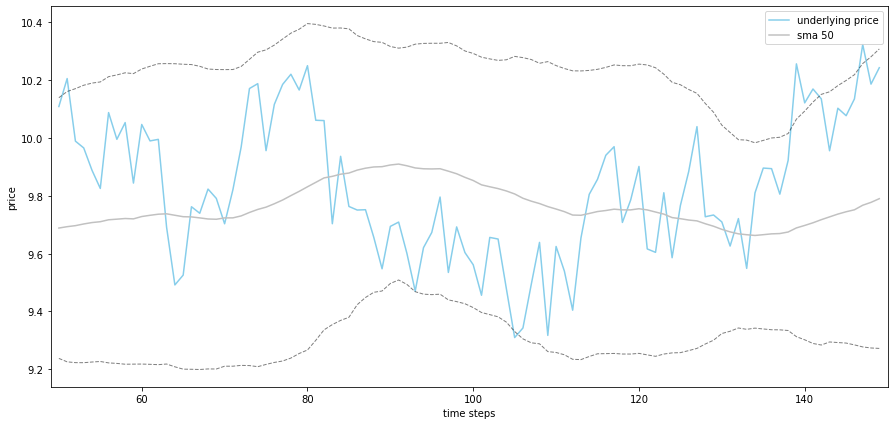

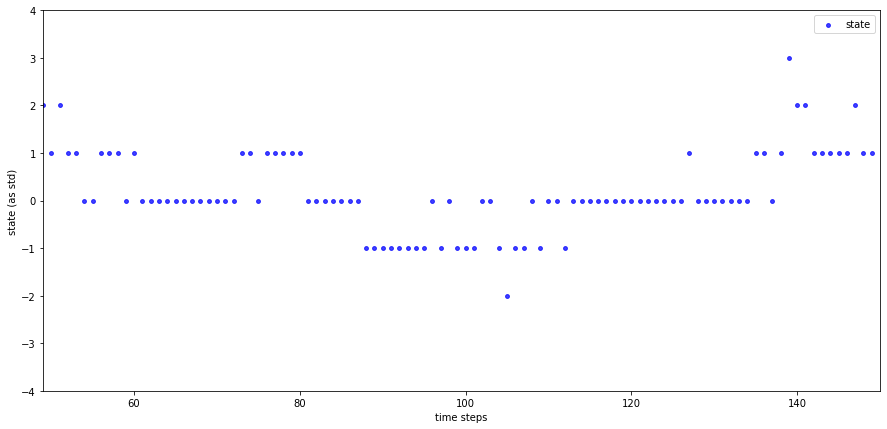

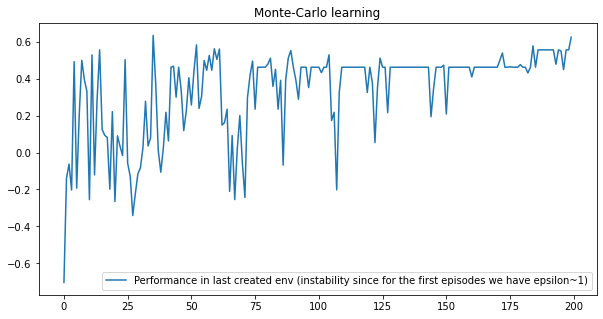

For trained agent for given env the best policy according his q-function
state => (-2, -1), action => open_long
state => (-1, -1), action => close_short
state => (0, -1), action => close_short
state => (1, -1), action => close_short
state => (2, -1), action => open_long
state => (3, -1), action => close_short
state => (-2, 0), action => open_long
state => (-1, 0), action => open_short
state => (0, 0), action => open_long
state => (1, 0), action => open_short
state => (2, 0), action => open_short
state => (3, 0), action => open_long
state => (-2, 1), action => close_long
state => (-1, 1), action => close_long
state => (0, 1), action => close_long
state => (1, 1), action => open_short
state => (2, 1), action => close_long
state => (3, 1), action => close_long


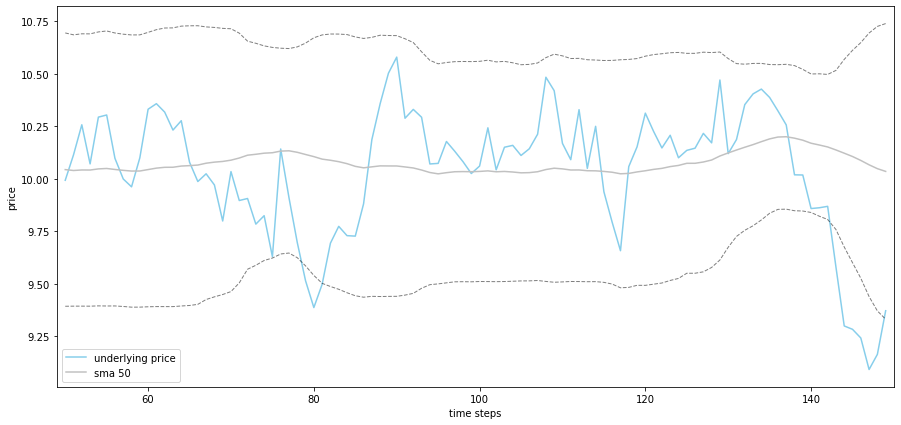

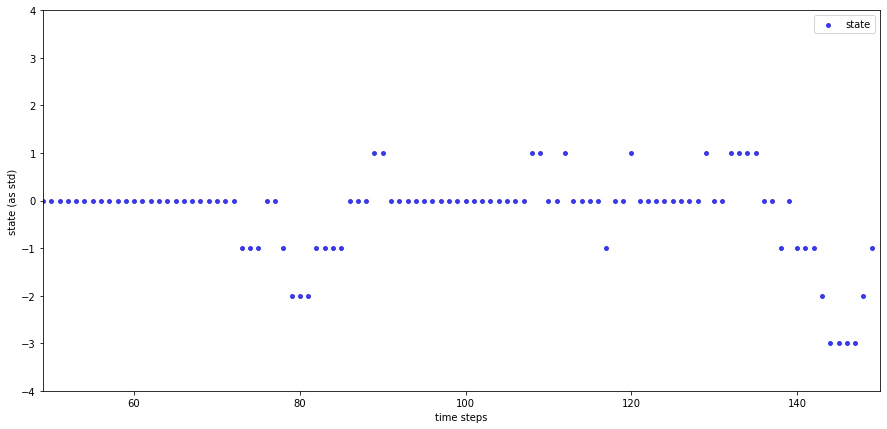

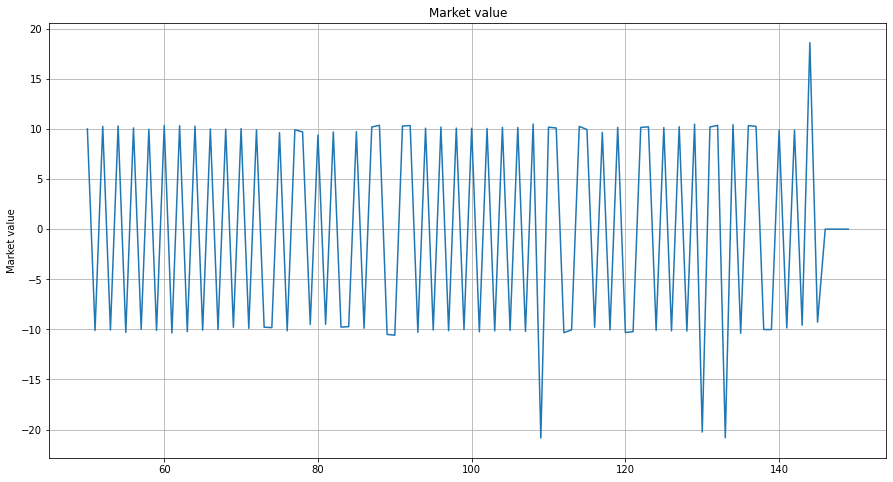

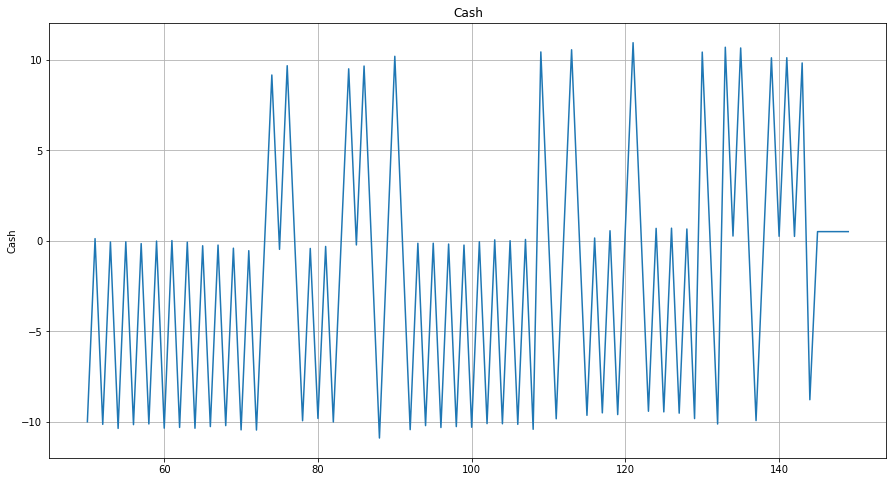

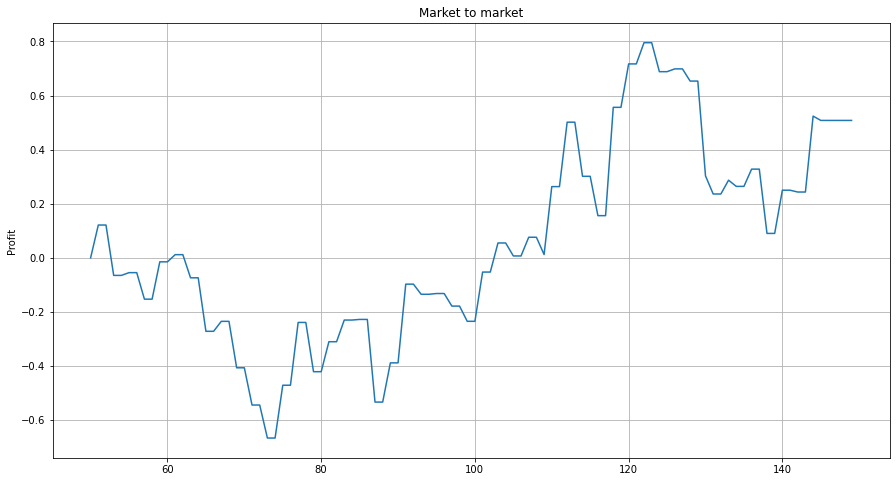

CPU times: total: 31.7 s
Wall time: 31.7 s


{(-4, -1): {'open_long': 0,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0},
 (-3, -1): {'open_long': 0,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0},
 (-2, -1): {'open_long': 0.10513625259706547,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0.05072267451695292},
 (-1, -1): {'open_long': -0.0014424001728812752,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0.05294687861245904},
 (0, -1): {'open_long': 0.027521851726245668,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0.034866662366107984},
 (1, -1): {'open_long': -0.04708165073456749,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0.03842421537340378},
 (2, -1): {'open_long': 0.11020759689002592,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': -0.027673683224352517},
 (3, -1): {'open_long': 0.004092822895268304,
  'close_long': -inf,
  'open_short': -inf,
  'close_short': 0.042587487343448485},
 (4, -1): {'open_long': 0,
  'clos

In [163]:
%%time

'''
    here is an example of typical interface for agent, env, rl-algorithm
'''

# atittude to risk
risk_avertive = True

# create env object
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)

# set parameters for learning
episode_n = 200
trajectory_len = len(env.states)
gamma = 0.9
alpha = 0.7
beta = 0.25

# create RL-agent object ( state for env and actions as inputs )
#agent = RL_agent(env.state_space, env.action_space, risk_avertive=risk_avertive, max_pos=1)

# create RL-algorithm object ( => env, agent, RL-params* )
rl_ET_Q    = Q_learning(env, agent, episode_n, trajectory_len, gamma, alpha)
for i in range(5):
    rl_ET_Q    = Q_learning(env, agent, episode_n, trajectory_len, gamma, alpha)
    rews_etq = rl_ET_Q.simulate()
    

# plot total rewards
env.render()
plt.figure(figsize=(10,5))
plt.plot(rews_etq, label=f'Performance in last created env (instability since for the first episodes we have epsilon~1)')
plt.title('Monte-Carlo learning')
plt.legend()
plt.show()

# show the policy
print('For trained agent for given env the best policy according his q-function')
for state in agent.states:
    if abs(np.mean(
        np.asarray(list(agent.q_function[state].values()))[(np.asarray(list(agent.q_function[state].values())) > -10**10)])) > 1e-6:
        print(f'state => {state}, action =>',
            f'{agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), 0)}')
    else: 
        pass#print(f'state => {state}, action => no cases for this state')
        
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)
env.render()
m2m, pos = back_test(agent, env, cost_bps=0, render=True)
agent.q_function

In [175]:
from numba import jit
@jit
def learn_agent(pair):
    episode_n = 200
    trajectory_len = len(env.states)
    gamma = 0.9
    alpha = 0.7
    beta = 0.25
    rl_ET_Q    = Q_learning(pair[0], pair[1], episode_n, trajectory_len, gamma, alpha)
    rews_etq = rl_ET_Q.simulate()

C:\Users\prof-\AppData\Local\Temp\ipykernel_55056\1018684389.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def learn_agent(pair):


In [170]:
# atittude to risk
risk_avertive = True

# create env object
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)

# set parameters for learning
episode_n = 200
trajectory_len = len(env.states)
gamma = 0.9
alpha = 0.7
beta = 0.25

N = 5

# create multi-agents
agents = [RL_agent(env.state_space, env.action_space, risk_avertive=risk_avertive, max_pos=2) for _ in range(N)]
envs   = [OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive) for _ in range(N)]
pairs = [(en,ag) for en, ag in zip(envs, agents)]

In [176]:
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(8) as pool:
    results = pool.map(learn_agent, pairs)

C:\Users\prof-\AppData\Local\Temp\ipykernel_55056\1018684389.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "learn_agent" failed type inference due to: Untyped global name 'env': Cannot determine Numba type of <class '__main__.OU_env'>

File "..\..\..\AppData\Local\Temp\ipykernel_55056\1018684389.py", line 5:
<source missing, REPL/exec in use?>

  @jit
C:\Users\prof-\AppData\Roaming\Python\Python39\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "learn_agent" was compiled in object mode without forceobj=True.

File "..\..\..\AppData\Local\Temp\ipykernel_55056\1018684389.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\prof-\AppData\Roaming\Python\Python39\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecat